# **ANT ALGORITHM BY KELOMPOK 9**
1. Heri Khariono - 18081010002
2. Devan Cakra Mudra Wijaya - 18081010013
3. Ika Nur Habibah - 18081010033
4. Trisa Pratiwi - 18081010036
5. Rifky Akhmad Fernanda - 18081010126

# **1. Import Libraries**

In [185]:
#**********************************IMPORT LIBRARIES*******************************
#Library untuk operasi matematika
import math
#Library untuk membentuk dan memanipulasi segala bentuk graf dan jaringan
import networkx as nx
#Library untuk visualisasi grafik 
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from pylab import *
#Library untuk mendukung komputasi numerik
import numpy as np
#Library untuk analisis dan manipulasi data tingkat tinggi
import pandas as pn
#Library untuk untuk mengukur waktu eksekusi
from time import time 

# **2. Read Data**

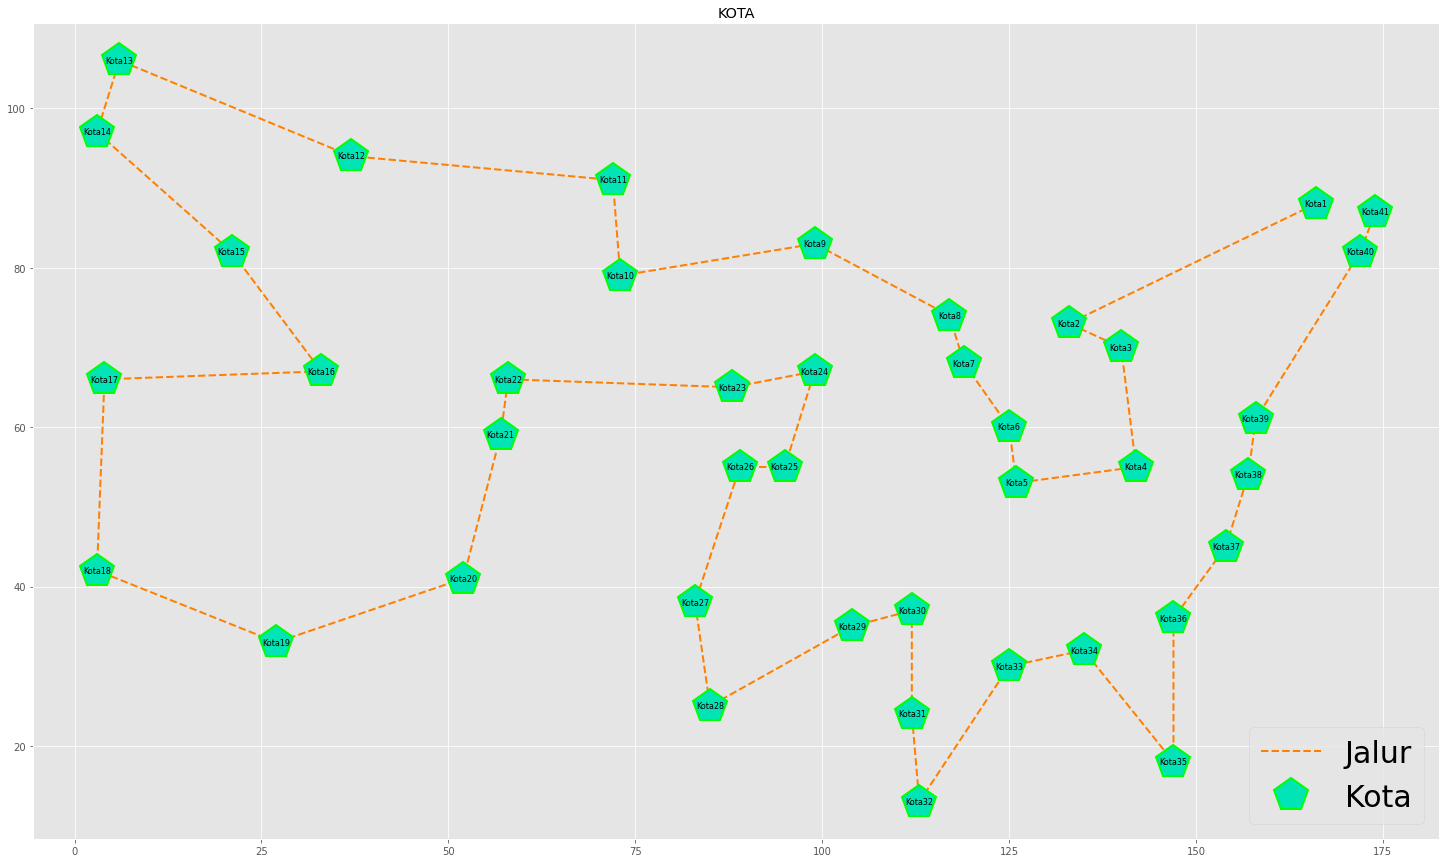

In [192]:
read_jarak_antarkota = pn.read_excel('https://raw.githubusercontent.com/devancakra/Ant-Algorithm-Pencarian-Rute-Tercepat/master/jarak_antarkota.xlsx') 
read_kota = pn.read_excel('https://raw.githubusercontent.com/devancakra/Ant-Algorithm-Pencarian-Rute-Tercepat/master/kota.xlsx') 
arr_kota = np.array(read_kota)
arr_jarak_antarkota = np.array(read_jarak_antarkota)

#Grafik Map
def Grafik_Map(simpul,sudut):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(25.200,15))
    x = simpul[:,0]
    y = simpul[:,1]
    #Mencetak garis
    plt.plot( x, y, '--',x, y, 'p',color='#FF8000',#Warna garis
             markersize=35, #Ukuran objek
             linewidth=2,
             markerfacecolor='#00E4B6',#Warna objek
             markeredgecolor='#00FF00',#Warna tepi objek
             markeredgewidth=2)#Ketebalan tepi titik

    plt.title("KOTA")
    legend(("Jalur","Kota"), prop = {'size': 30}, loc='lower right')
    plt.grid(True)
    #plt.tight_layout()
    for i in range (len(simpul)):
        #Pengidentifikasi kota (nomor setiap kota)
        plt.annotate("Kota"+str(i+1), 
                     size=8, 
                     xy=simpul[i],
                     horizontalalignment='center',
                     verticalalignment='center') #Kotak dalam anotasi bbox = dict (facecolor = 'none', edgecolor = 'black', boxstyle = 'round, pad = 1')

Grafik_Map(arr_kota,arr_jarak_antarkota)

# **3. Implementasi Algoritma Ant**

1. Transisi status, Pembaruan Feromon Lokal, Pembaruan Feromon Global

In [187]:
import random
class Rute_Cepat_ACO:
    #Sub class Tepi = objek tepi yang menyimpan simpul a, simpul b, jarak antara ab, dan feromon koneksi 
    class Tepi:
        def __init__(self, a, b, jarak_ab, feromon_koneksi):
            self.a = a
            self.b = b
            self.jarak_ab = jarak_ab
            self.feromon_koneksi = feromon_koneksi

    #Sub class Semut
    class Semut:
        def __init__(self, alpha, beta, num_simpul, tepi):
            self.alpha = alpha
            self.beta = beta
            self.num_simpul = num_simpul
            self.tepi = tepi
            self.survei = None
            self.jarak_tempuh = 0.0
            
        #Metode untuk memilih simpul berikutnya yang akan dikunjungi, memvalidasi bahwa node tersebut belum pernah dikunjungi.
        def _select_simpul(self):
            persebaran = 0.0 #mulai persebaran dari nol,lalu pilih jalur secara acak
            k_simpul_sepi = [node for node in range(self.num_simpul) if node not in self.jalur] #Simpul Sepi
            heuristic_total = 0.0 #Peningkatan jarak jalan
            for simpul_sepi in k_simpul_sepi:
                heuristic_total += self.tepi[self.jalur[-1]][simpul_sepi].jarak_ab
            for simpul_sepi in k_simpul_sepi:
                persebaran += pow(self.tepi[self.jalur[-1]][simpul_sepi].feromon_koneksi, self.alpha) * \
                                  pow((heuristic_total / self.tepi[self.jalur[-1]][simpul_sepi].jarak_ab), self.beta)
            nilai_random = random.uniform(0.0, persebaran)
            pos_sebar = 0.0
            for simpul_sepi in k_simpul_sepi:
                pos_sebar += pow(self.tepi[self.jalur[-1]][simpul_sepi].feromon_koneksi, self.alpha) * \
                                  pow((heuristic_total / self.tepi[self.jalur[-1]][simpul_sepi].jarak_ab), self.beta)
                if pos_sebar >= nilai_random:
                    return simpul_sepi

        #Metode untuk menemukan cara untuk memilih jalur
        def survei_jalur(self):
            self.jalur = [random.randint(0, self.num_simpul - 1)]
            while len(self.jalur) < self.num_simpul:
                self.jalur.append(self._select_simpul())
            return self.jalur

        #Jarak antara satu simpul dengan simpul lainnya
        def get_jarak_tempuh(self):
            self.jarak_tempuh = 0.0
            for i in range(self.num_simpul):
                self.jarak_tempuh += self.tepi[self.jalur[i]][self.jalur[(i + 1) % self.num_simpul]].jarak_ab
            return self.jarak_tempuh
        
        
    # Definisi atribut untuk objek kelas Rute_Cepat_ACO
    def __init__(self, mode='ACS', jumlah_semut=10, alpha=1.0, beta=3.0, rho=0.1, 
                 feromon_tersimpan=1.0, feromon_koneksi=1.0, langkah=100, v_simpul=None, m_jarak=None, posting=None):
        self.mode = mode
        self.jumlah_semut = jumlah_semut
        self.rho = rho
        self.feromon_tersimpan = feromon_tersimpan
        self.langkah = langkah
        self.num_simpul = len(v_simpul)
        self.v_simpul = v_simpul
        if posting is not None:
            self.posting = posting
        else:
            self.posting = range(1, self.num_simpul + 1)

        #Deklarasi list tepi kosong
        self.tepi = [[None] * self.num_simpul for _ in range(self.num_simpul)]

        #Membuat objek tepi untuk setiap tuple i = a j = b dan menyimpannya di list tepi, pada akhirnya array n*n dibuat, dengan n = jumlah simpul
        for i in range(self.num_simpul):
            for j in range(self.num_simpul):
                self.tepi[i][j] = self.tepi[j][i] = self.Tepi(i, j, m_jarak[i][j],feromon_koneksi) #Simpan objek bertipe Endge di list tepi
        self.semut = [self.Semut(alpha, beta, self.num_simpul, self.tepi) for _ in range(self.jumlah_semut)] #Buat semut dalam array yang terdiri dari objek kelas Semut
        self.jalur_terbaik = None #Atribut jalan terbaik
        self.jarak_terbaik = float("inf") #Atribut untuk jarak minimum
    
    #Metode yang menambahkan feromon ke jalan
    def _add_feromon(self, jalur, jarak_ab, weight=1.0):
        add_feromon = self.feromon_tersimpan / jarak_ab
        for i in range(self.num_simpul):
            self.tepi[jalur[i]][jalur[(i + 1) % self.num_simpul]].feromon_koneksi += jarak_ab * add_feromon

    #Siklus perutean setiap semut 
    def _acs(self):
        for k_langkah in range(self.langkah):
            for k_semut in self.semut:
                self._add_feromon(k_semut.survei_jalur(), k_semut.get_jarak_tempuh())
                if k_semut.jarak_tempuh < self.jarak_terbaik:
                    self.jalur_terbaik = k_semut.jalur
                    self.jarak_terbaik = k_semut.jarak_tempuh
            for i in range(self.num_simpul):
                for j in range(i + 1, self.num_simpul):
                    self.tepi[i][j].feromon_koneksi *= (1.0 - self.rho)

    #Metode yang dimuat saat menjalankan kelas
    def run(self):
        self._acs()

    #Membuat grafik hasil
    def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=10, dpi=120, save=True, name=None):
        fig = plt.figure(figsize=(25.200,15))
        x = [self.v_simpul[i][0] for i in self.jalur_terbaik]
        x.append(x[0])
        y = [self.v_simpul[i][1] for i in self.jalur_terbaik]
        y.append(y[0])

        #Mencetak garis
        plt.plot( x, y, '--',x, y, 'p',color='#FF8000',#Warna garis
            markersize=35, #Ukuran objek
            linewidth=2,
            markerfacecolor='#00E4B6',#Warna objek
            markeredgecolor='#00FF00',#Warna tepi objek
            markeredgewidth=2)#Ketebalan tepi titik
        
        #Membuat tambalan untuk diletakkan di kanan atas gambar
        handle1 = mpatches.Patch(color='white', label='Semut: '+str(self.jumlah_semut))
        handle2 = mpatches.Patch(color='white', label='Langkah: '+str(self.langkah))
        handle3 = mpatches.Patch(color='white', label='Rho: '+str(self.rho))
        ax = plt.gca().add_artist(plt.legend(handles=[handle1,handle2,handle3],prop = {'size': 12}))
        
        #Hasil
        handle4 = mpatches.Patch(color='white', label='Jarak tempuh: '+str(round(self.jarak_terbaik, 2)))
        ax = plt.gca().add_artist(plt.legend(handles=[handle4],prop = {'size': 12},loc='lower left'))
        
        #Data grafik
        plt.title(" Perutean ACS - "+self.mode)
        legend(("Jalur","Kota"), prop = {'size': 30}, loc='lower right')
        plt.grid(True)
        
        #Pengenal kota (nomor tiap kota)
        for i in self.jalur_terbaik:
            plt.annotate("Kota"+str(i+1),
                         size=8, 
                         xy=self.v_simpul[i],
                         horizontalalignment='center',
                         verticalalignment='center') #Kotak dalam anotasi bbox = dict (facecolor = 'none', edgecolor = 'black', boxstyle = 'round, pad = 1')
        plt.show()
        return self.jarak_terbaik

2. Konfigurasi perutean

In [188]:
#Mendefinisikan fungsi untuk mengirim konfigurasi yang berbeda secara teratur
def config(tipe, ts, lg, t_evap):
    acs = Rute_Cepat_ACO(mode=tipe, jumlah_semut=ts, langkah=lg, v_simpul=arr_kota, m_jarak=arr_jarak_antarkota, rho=t_evap)
    acs.run()
    jarak_jalur_akhir = acs.plot()
    return jarak_jalur_akhir
    
#Konfigurasi yang berbeda didefinisikan
txt_config = [] #Teks konfigurasi
jumlah_semut = [] #Ukuran koloni
langkah = [] #Jumlah langkah total
rho = [] #Tingkat penguapan fermones ANTARA 0 dan 1

txt_config.append('Konfigurasi 1'); jumlah_semut.append(50); langkah.append(10); rho.append(0.1);
txt_config.append('Konfigurasi 2'); jumlah_semut.append(100); langkah.append(10); rho.append(0.1);
txt_config.append('Konfigurasi 3'); jumlah_semut.append(250); langkah.append(10); rho.append(0.1);
txt_config.append('Konfigurasi 4'); jumlah_semut.append(50); langkah.append(30); rho.append(0.5);
txt_config.append('Konfigurasi 5'); jumlah_semut.append(90); langkah.append(40); rho.append(0.5);
txt_config.append('Konfigurasi 6'); jumlah_semut.append(150); langkah.append(30); rho.append(0.5);
txt_config.append('Konfigurasi 7'); jumlah_semut.append(50); langkah.append(50); rho.append(0.1);
txt_config.append('Konfigurasi 8'); jumlah_semut.append(200); langkah.append(90); rho.append(0.1);
txt_config.append('Konfigurasi 9'); jumlah_semut.append(150); langkah.append(50); rho.append(0.1);
txt_config.append('Konfigurasi 10'); jumlah_semut.append(80); langkah.append(100); rho.append(0.5);
txt_config.append('Konfigurasi 11'); jumlah_semut.append(100); langkah.append(100); rho.append(0.5);
txt_config.append('Konfigurasi 12'); jumlah_semut.append(150); langkah.append(100); rho.append(0.5);

jarak_ab = [] #Vektor perpindahan akhir di setiap konfigurasi
tempo = [] #Vektor waktu eksekusi algoritma di setiap konfigurasi
for i in range(len(txt_config)):
    start_time = time()
    jarak_ab.append(config(txt_config[i], jumlah_semut[i], langkah[i], rho[i]))
    tempo.append(time()-start_time)

Output hidden; open in https://colab.research.google.com to view.

3. Pemilihan Hasil Terbaik

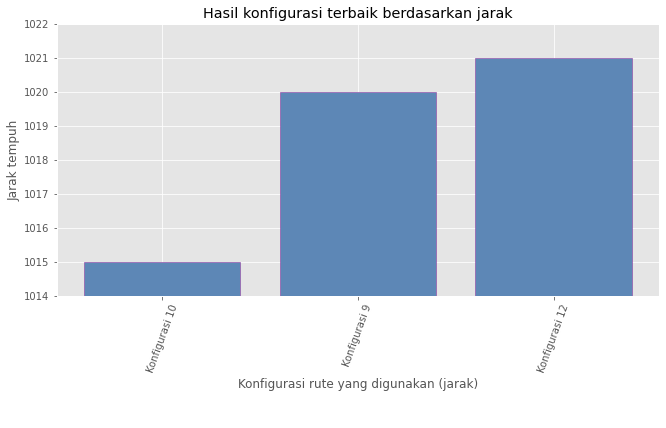

In [189]:
#Grafik hasil tiga rute terbaik berdasarkan jarak
index1=jarak_ab.index(sorted(jarak_ab,reverse=False)[0])
index2=jarak_ab.index(sorted(jarak_ab,reverse=False)[1])
index3=jarak_ab.index(sorted(jarak_ab,reverse=False)[2])
if index2==index1:
    index2=index2+1
if index2==index3:
    index3=index3+1
plt.style.use('ggplot')
fig = plt.figure(figsize=(10.80,5))
plt.bar(range(3),sorted(jarak_ab,reverse=False)[0:3], edgecolor='#93329F', color='#5D87B6')
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(jarak_ab[index1],jarak_ab[index2],jarak_ab[index3])-1, max(jarak_ab[index1],jarak_ab[index2],jarak_ab[index3])+1)
plt.title("Hasil konfigurasi terbaik berdasarkan jarak")
plt.ylabel('Jarak tempuh')
plt.xlabel('Konfigurasi rute yang digunakan (jarak)\n\n')
plt.show()

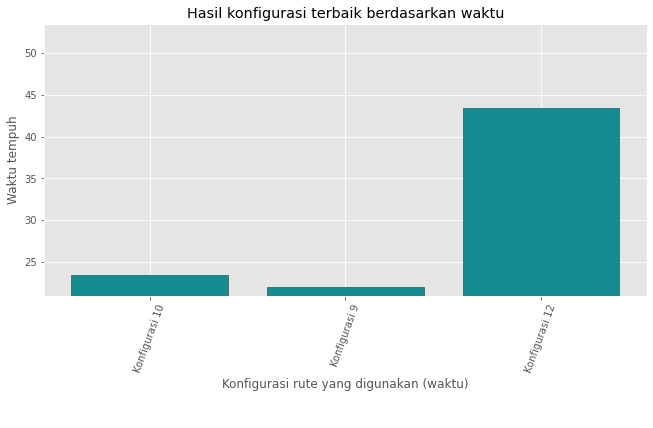

In [190]:
#Grafik hasil tiga rute terbaik berdasarkan waktu
plt.style.use('ggplot')
fig = plt.figure(figsize=(10.80,5))
plt.bar(range(3),(tempo[index1],tempo[index2],tempo[index3]), edgecolor='#282623', color='#138d90')
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(tempo[index1],tempo[index2],tempo[index3])-1, max(tempo[index1],tempo[index2],tempo[index3])+10)
plt.title("Hasil konfigurasi terbaik berdasarkan waktu")
plt.ylabel('Waktu tempuh')
plt.xlabel('Konfigurasi rute yang digunakan (waktu)\n\n')
plt.show()

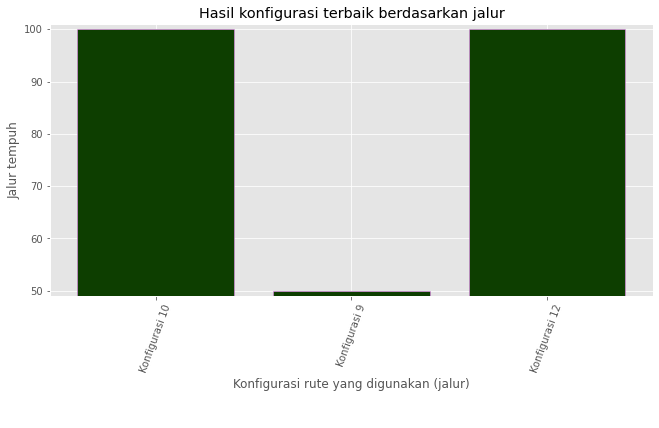

In [191]:
#Grafik hasil tiga rute terbaik berdasarkan jalur
plt.style.use('ggplot')
fig = plt.figure(figsize=(10.80,5))
plt.bar(range(3),(langkah[index1],langkah[index2],langkah[index3]), edgecolor='#F387FF', color='#0D3E00')
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(langkah[index1],langkah[index2],langkah[index3])-1, max(langkah[index1],langkah[index2],langkah[index3])+1)
plt.title("Hasil konfigurasi terbaik berdasarkan jalur")
plt.ylabel('Jalur tempuh')
plt.xlabel('Konfigurasi rute yang digunakan (jalur)\n\n')
plt.show()